# Analysis of the combined ATAC-seq data in MEF, including the Brg1 KD data

In [1]:
library(chromVARmotifs)
library(chromVAR)
data("homer_pwms") 
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
library(SummarizedExperiment)
library(gplots)
library(circlize)
register(MulticoreParam(4))
library(dplyr)
library(ComplexHeatmap)
library(rtracklayer)
library(parallel)
devtools::load_all('../compbio')



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

### Read the ATAC-seq read counts data for each sample and count the motifs at each interval
This file was generated by `ATAC_seq_preprocess.Rmd`

In [2]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228a/all_ATAC.rds')))
se

class: RangedSummarizedExperiment 
dim: 152282 30 
metadata(0):
assays(1): counts
rownames(152282): chr1 chr1 ... chrY chrY
rowData names(3): score source group
colnames(30): EB_Dox_D25_rep1 EB_Dox_D25_rep2 ...
  MEF_Brg1_KD_NoDox_D7_rep1 MEF_Brg1_KD_NoDox_D7_rep2
colData names(3): bw_file name group

In [3]:
# remove intervals that have reads in at zero or one condition
se <- se[rowSums(assays(se)$counts > 0) >= 2] 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
colData(se)$is_MEF <- grepl('^MEF_', colData(se)$group)
colData(se)$is_EB <- grepl('^EB_', colData(se)$group)
colData(se)$is_flk1pos <- grepl('Flk1pos', colData(se)$group)
colData(se)$is_dox <- grepl('_Dox_', colData(se)$group)
colData(se)$is_Brg1_KD <- grepl('_Brg1_', colData(se)$group)
time <- gsub('_Flk1pos', '', gsub('.+_(D.+)$', '\\1', colData(se)$group))
time[time == 'MEF_NoDox'] <- 'D0'
colData(se)$time <- time

In [4]:
MEF_cols <- colorpanel(4, low = 'black', high = 'green') # time
EB_col <- 'red'
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D25' = EB_col,
  'EB_Dox_D25' = EB_col,
  'EB_Dox_D25_Flk1pos' = EB_col,
  
  'MEF_Brg1_KD_D0' = MEF_cols[1],
  'MEF_Brg1_KD_Dox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_Dox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_Dox_D7' = MEF_cols[4],
  
  'MEF_Brg1_KD_NoDox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_NoDox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_NoDox_D7' = MEF_cols[4]
)
pch <- rep(21, ncol(se))
pch[colData(se)$is_Brg1_KD] <- 24
colData(se)$pch <- pch
colData(se)$bg <- group2col[as.character(colData(se)$group)]
colData(se)$col <- group2col[as.character(colData(se)$group)]
colData(se)                             

DataFrame with 30 rows and 12 columns
                                                                                                                                                        bw_file
                                                                                                                                                       <factor>
EB_Dox_D25_rep1                                     https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep1_treat_pileup.bw
EB_Dox_D25_rep2                                     https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep2_treat_pileup.bw
EB_NoDox_D25_rep1                                 https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep1_treat_pileup.bw
EB_NoDox_D25_rep2                                 https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep2_treat_pileup.bw
EB

### Use chromVAR to compare the difference between WT Dox, Brg1 KD Dox, and Brg1 KD No Dox at all time points in MEF reprogramming

In [5]:
set.seed(1)
include <- colData(se)$is_MEF
#include <- colData(se)$is_MEF & colData(se)$time == 'D7' & !colData(se)$is_flk1pos
#include <- colData(se)$is_MEF & colData(se)$time == 'D7'
#include <- colData(se)$is_MEF & colData(se)$time == 'D2'
se_subset <- se[, include]
se_subset <- se_subset[rowSums(assays(se_subset)$counts > 0) >= 2]
motif_ix <- matchMotifs(homer_pwms, se_subset, genome = 'mm10')
dev_subset <- computeDeviations(object = se_subset, annotations = motif_ix)
v_subset <- computeVariability(dev_subset)

In [6]:
# PCA of the motif deviations 
m <- v_subset$p_value_adj < 0.05
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
s <- prcomp(assays(dev_subset)$z[m, ])
eigs <- s$sdev^2
z <- s$rotation

pc_x <- 1; pc_y <- 2
cex <- 3

par(mar = c(5, 5, 5, 5))
options(repr.plot.width=7, repr.plot.height=7)
plot(
  z[, pc_x], z[, pc_y], 
  pch = colData(se_subset)$pch, 
  bg = colData(se_subset)$bg, 
  col = colData(se_subset)$col, 
  cex = cex, 
  xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), 
  ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100)
)
points(
  z[colData(se_subset)$is_dox, pc_x], z[colData(se_subset)$is_dox, pc_y], 
  pch = colData(se_subset)$pch[colData(se_subset)$is_dox], 
  col = 'blue', 
  cex = cex, 
  lwd = 3
)
points(
  z[colData(se_subset)$is_flk1pos, pc_x], z[colData(se_subset)$is_flk1pos, pc_y], 
  pch = 3, 
  col = 'pink', 
  cex = cex, 
  lwd = 3
)

# of significant motifs: 309(332)


#### Observations:
* Brg1 KD cell with No Dox induction did __not__ have significant changes at the first 48 hours.  However, Brg1 KD cells are different from the WT MEF cells at day 0 (before Dox induction), suggesting that the starting cell population have different chromatin landscape.  This is one concern of these experiments.

### Compare the difference between WT Dox, Brg1 KD Dox, and Brg1 KD No Dox at D0, D1 and D2

In [9]:
set.seed(1)
include <- colData(se)$is_MEF & colData(se)$time %in% c('D0', 'D1', 'D2')
se_subset <- se[, include]
se_subset <- se_subset[rowSums(assays(se_subset)$counts > 0) >= 2]
motif_ix <- matchMotifs(homer_pwms, se_subset, genome = 'mm10')
dev_subset <- computeDeviations(object = se_subset, annotations = motif_ix)
v_subset <- computeVariability(dev_subset)

# of significant motifs: 99(332)


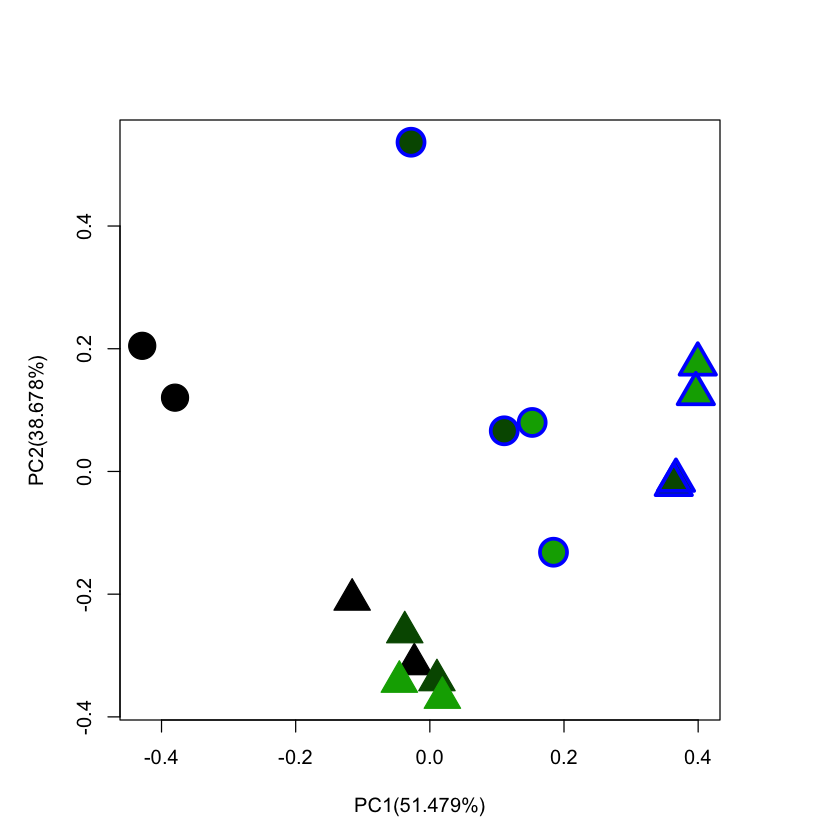

In [12]:
# PCA of the motif deviations 
m <- v_subset$p_value_adj < 1e-50
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
s <- prcomp(assays(dev_subset)$z[m, ])
eigs <- s$sdev^2
z <- s$rotation
pc_x <- 1; pc_y <- 2
cex <- 3

par(mar = c(5, 5, 5, 5))
options(repr.plot.width=7, repr.plot.height=7)
plot(
  z[, pc_x], z[, pc_y], 
  pch = colData(se_subset)$pch, 
  bg = colData(se_subset)$bg, 
  col = colData(se_subset)$col, 
  cex = cex, 
  xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), 
  ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100)
)
points(
  z[colData(se_subset)$is_dox, pc_x], z[colData(se_subset)$is_dox, pc_y], 
  pch = colData(se_subset)$pch[colData(se_subset)$is_dox], 
  col = 'blue', 
  cex = cex, 
  lwd = 3
)
points(
  z[colData(se_subset)$is_flk1pos, pc_x], z[colData(se_subset)$is_flk1pos, pc_y], 
  pch = 3, 
  col = 'pink', 
  cex = cex, 
  lwd = 3
)

# of significant motifs: 40(332)


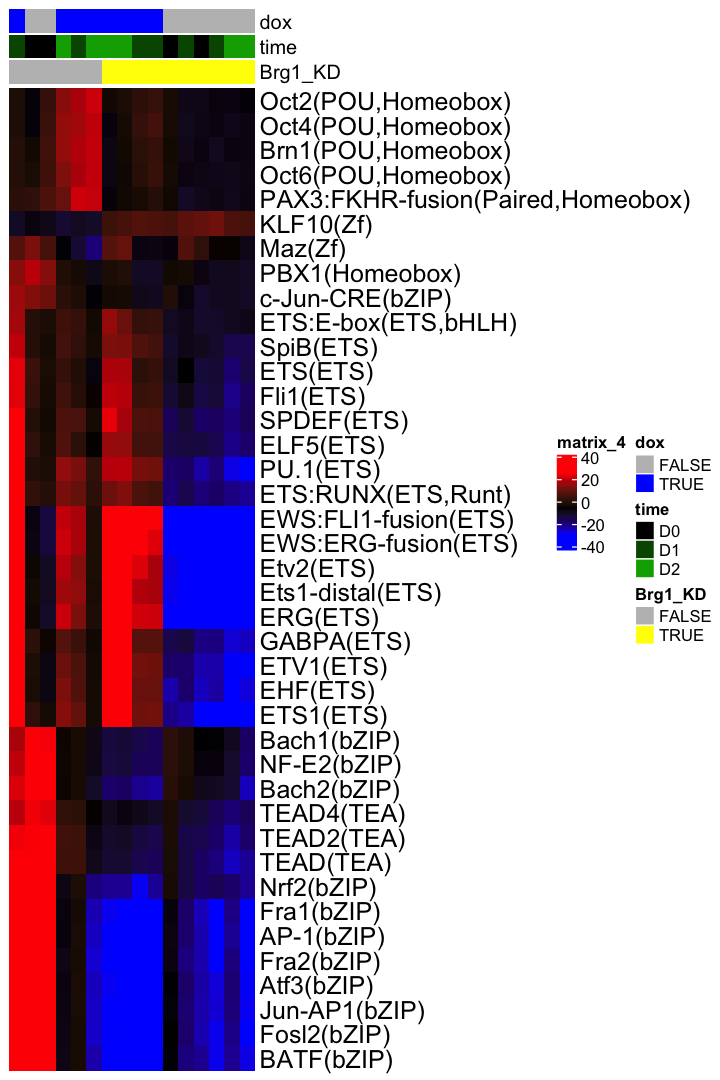

In [15]:
m <- v_subset$p_value_adj < 1e-200
Y <- assays(dev_subset)$z
rownames(Y) <- rowData(dev_subset)$name
Y <- Y[m, ]
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))

column_annotation <- HeatmapAnnotation(
#  flk1pos = colData(se_subset)$is_flk1pos,
  dox = colData(se_subset)$is_dox,
  time = colData(se_subset)$time,
  Brg1_KD = colData(se_subset)$is_Brg1_KD,
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray'),
    Brg1_KD  = c('TRUE' = 'yellow', 'FALSE' = 'gray'),
    time = c('D0' = MEF_cols[1], 'D1' = MEF_cols[2],'D2' = MEF_cols[3],'D7' = MEF_cols[4])
  )
)

col_fun <- colorRamp2(quantile(Y, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=6, repr.plot.height = nrow(Y) * 0.2 + 1)
Heatmap(
  Y,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_gp = gpar(fontsize = 15)
)

### Compare the difference between WT Dox, Brg1 KD Dox, and Brg1 KD No Dox at D7

In [16]:
set.seed(1)
include <- colData(se)$is_MEF & colData(se)$time == 'D7'
se_subset <- se[, include]
se_subset <- se_subset[rowSums(assays(se_subset)$counts > 0) >= 2]
motif_ix <- matchMotifs(homer_pwms, se_subset, genome = 'mm10')
dev_subset <- computeDeviations(object = se_subset, annotations = motif_ix)
v_subset <- computeVariability(dev_subset)

# of significant motifs: 229(332)


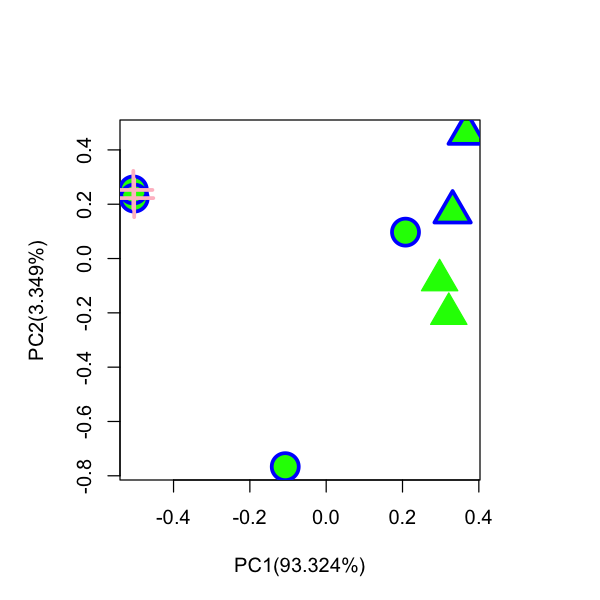

In [21]:
# PCA of the motif deviations 
m <- v_subset$p_value_adj < 1e-10
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
s <- prcomp(assays(dev_subset)$z[m, ])
eigs <- s$sdev^2
z <- s$rotation

pc_x <- 1; pc_y <- 2
cex <- 3

par(mar = c(5, 5, 5, 5))
options(repr.plot.width=5, repr.plot.height=5)
plot(
  z[, pc_x], z[, pc_y], 
  pch = colData(se_subset)$pch, 
  bg = colData(se_subset)$bg, 
  col = colData(se_subset)$col, 
  cex = cex, 
  xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), 
  ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100)
)
points(
  z[colData(se_subset)$is_dox, pc_x], z[colData(se_subset)$is_dox, pc_y], 
  pch = colData(se_subset)$pch[colData(se_subset)$is_dox], 
  col = 'blue', 
  cex = cex, 
  lwd = 3
)
points(
  z[colData(se_subset)$is_flk1pos, pc_x], z[colData(se_subset)$is_flk1pos, pc_y], 
  pch = 3, 
  col = 'pink', 
  cex = cex, 
  lwd = 3
)

# of significant motifs: 46(332)


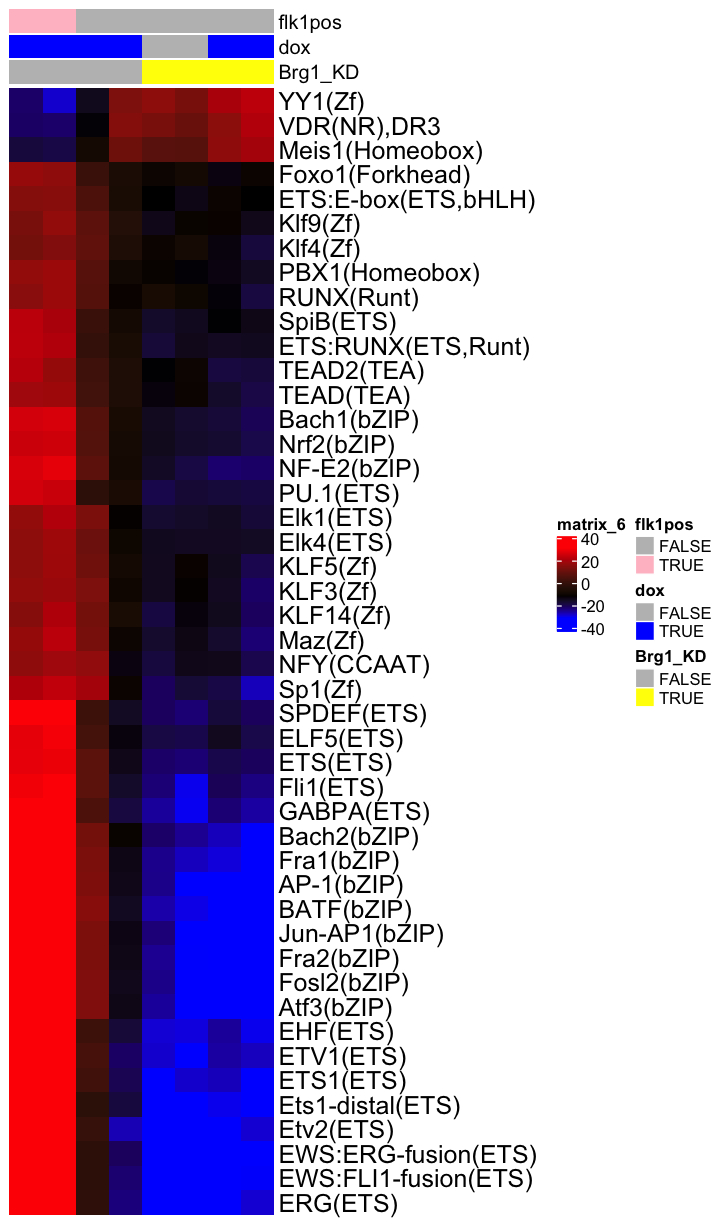

In [20]:
m <- v_subset$p_value_adj < 1e-200
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
Y <- assays(dev_subset)$z
rownames(Y) <- rowData(dev_subset)$name
Y <- Y[m, ]

column_annotation <- HeatmapAnnotation(
  flk1pos = colData(se_subset)$is_flk1pos,
  dox = colData(se_subset)$is_dox,
#  time = colData(se_subset)$time,
  Brg1_KD = colData(se_subset)$is_Brg1_KD,
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray'),
    Brg1_KD  = c('TRUE' = 'yellow', 'FALSE' = 'gray'),
    time = c('D0' = MEF_cols[1], 'D1' = MEF_cols[2],'D2' = MEF_cols[3],'D7' = MEF_cols[4])
  )
)

col_fun <- colorRamp2(quantile(Y, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=6, repr.plot.height = nrow(Y) * 0.2 + 1)
Heatmap(
  Y,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_gp = gpar(fontsize = 15)
)

* At D7, The Etv2 motif associated chromatin accessibility decreased in Brg1 KD cells, compared with the WT reprogramming.  This suggest that Brg1 may help to retain the Etv2 bindings on the chromatin, not so much related to the initialization. 

### Analysis of Etv2 ChIP-seq binding sites in Brg1 KD ATAC-seq

#### Split the Etv2 MEF D1 peaks into three groups
1. on at D1 and off at D7 (early)
2. off at D1 and on at D7 (late)
3. on at both D1 and D7 (sustained)

In [2]:
gr_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds' 
gr <- readRDS(gzcon(url(gr_url)))
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
peaks

GRanges object with 127559 ranges and 4 metadata columns:
           seqnames            ranges strand |
              <Rle>         <IRanges>  <Rle> |
       [1]     chr1   3037784-3037983      * |
       [2]     chr1   3490314-3490513      * |
       [3]     chr1   3531626-3531825      * |
       [4]     chr1   3671125-3671324      * |
       [5]     chr1   3671746-3671945      * |
       ...      ...               ...    ... .
  [127555]     chrY 90828936-90829135      * |
  [127556]     chrY 90836259-90836458      * |
  [127557]     chrY 90841624-90841823      * |
  [127558]     chrY 90842563-90842762      * |
  [127559]     chrY 90843810-90844009      * |
                                                                                                                 peak_id
                                                                                                             <character>
       [1]      /panfs/roc/scratch/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=2

In [3]:
bw_files <- c(
  'MEF_Dox_D1_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
  'MEF_Dox_D2_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
  'MEF_Dox_D7_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
  'MEF_NoDox_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
  'MEF_Dox_D1_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
  'MEF_Dox_D2_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
  'MEF_Dox_D7_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_Brg1_KD_D0' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_D0_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D1_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D1_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D7_treat_pileup.bw',
  'MEF_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_treat_pileup.bw',
  'MEF_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_treat_pileup.bw',
  'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_treat_pileup.bw',
  'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw',
  'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw'
)

In [4]:
# Download the bigwig files.  It appear sthat rtracklayer::import does not support importing bigwig files with URL starting with 'https://'
s3_bw_files <- gsub('https://s3.msi.umn.edu/', 's3://', bw_files)
local_bw_files <- gsub('https://s3.msi.umn.edu/gongx030/datasets/', './data/', bw_files)
commands <- sprintf('s3cmd get --recursive %s %s', s3_bw_files, local_bw_files)
lapply(commands, function(command) system(command))
       

[[1]]
[1] 64

[[2]]
[1] 64

[[3]]
[1] 64

[[4]]
[1] 64

[[5]]
[1] 64

[[6]]
[1] 64

[[7]]
[1] 64

[[8]]
[1] 64

[[9]]
[1] 64

[[10]]
[1] 64

[[11]]
[1] 64

[[12]]
[1] 64

[[13]]
[1] 64

[[14]]
[1] 64

[[15]]
[1] 64

[[16]]
[1] 64

[[17]]
[1] 64

[[18]]
[1] 64

[[19]]
[1] 64

#### Select the **sustained** Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction. 

In [13]:
is_sustained <- peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']
peaks_sustained <- peaks[is_sustained]
cat(sprintf('# of sustained Etv2 ChIP-seq peaks: %d', sum(is_sustained)))

# of sustained Etv2 ChIP-seq peaks: 12170

In [14]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(peaks_sustained)[1]

In [15]:
group_cols <- c(
  'MEF_Dox_D1_Etv2' = 'red',
  'MEF_Dox_D2_Etv2' = 'red',
  'MEF_Dox_D7_Etv2' = 'red',
  'MEF_NoDox_Brg1' = 'purple',
  'MEF_Dox_D1_Brg1' = 'purple',
  'MEF_Dox_D2_Brg1' = 'purple',
  'MEF_Dox_D7_Brg1' = 'purple',
  'MEF_Brg1_KD_D0' = 'blue',
  'MEF_Brg1_KD_Dox_D1' = 'blue',
  'MEF_Brg1_KD_Dox_D2' = 'blue',
  'MEF_Brg1_KD_Dox_D7' = 'blue',
  'MEF_Brg1_KD_NoDox_D1' = 'blue',
  'MEF_Brg1_KD_NoDox_D2' = 'blue',
  'MEF_Brg1_KD_NoDox_D7' = 'blue',
  'MEF_Dox_D1' = 'blue',
  'MEF_Dox_D2' = 'blue',
  'MEF_Dox_D7' = 'blue',
  'MEF_Dox_D7_Flk1pos' = 'blue',
  'MEF_NoDox' = 'blue'
)

### Download the ATAC-seq summits for Brg1 KD at D7 post Etv2 induction and ATAC-seq summits for WT MEF reprogramming at D7 post induction

In [9]:
# ATAC-seq summits of Brg1 KD at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_summits.bed'
peaks_Brg1KD_D7 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_Brg1KD_D7 <- GRanges(seqnames = peaks_Brg1KD_D7[, 1], range = IRanges(peaks_Brg1KD_D7[, 2], peaks_Brg1KD_D7[, 3]))

# ATAC-seq summits WT MEF reprogramming at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed'
peaks_D7_Flk1pos <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_D7_Flk1pos <- GRanges(seqnames = peaks_D7_Flk1pos[, 1], range = IRanges(peaks_D7_Flk1pos[, 2], peaks_D7_Flk1pos[, 3]))

# ATAC-seq blacklist
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/datasets=blacklists_version=20190827a/mm10.blacklist.bed.gz'
peaks_blacklist <- gzcon(url(bed_file))
peaks_blacklist <- readLines(peaks_blacklist)
peaks_blacklist <- read.table(textConnection(peaks_blacklist), header = FALSE, sep = '\t')
peaks_blacklist <- GRanges(seqnames = peaks_blacklist[, 1], range = IRanges(peaks_blacklist[, 2], peaks_blacklist[, 3]))

## Analysis of sustained Etv2 peaks

In [125]:
peak_name <- 'sustained_Etv2'
n2m_files <- sprintf('data/normalizeToMatrix/peaks=%s_group=%s_extend=%d_w=%d_smooth=%s_target_ratio=%.3f.rds', peak_name, names(bw_files), extend, w, smooth, target_ratio)
mat <- get_normalizeToMatrix(
  local_bw_files, 
  n2m_files, 
  peaks_sustained, 
  extend = extend, 
  w = w, 
  smooth = smooth, 
  target_ratio = target_ratio, 
  mc.cores = 2, 
  force = FALSE
)
names(mat) <- names(bw_files)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

INFO [2020-09-03 13:44:53] # peaks: 12170
INFO [2020-09-03 13:44:53] target width: 200


### Divide the "sustained" Etv2 peaks to two group based on the ATAC-seq in Brg1 KD D7

In [224]:
open_Brg1KD_D7 <- peaks_sustained %over% peaks_Brg1KD_D7
open_D7_Flk1pos <-peaks_sustained %over% peaks_D7_Flk1pos
is_black <- peaks_sustained %over% peaks_blacklist

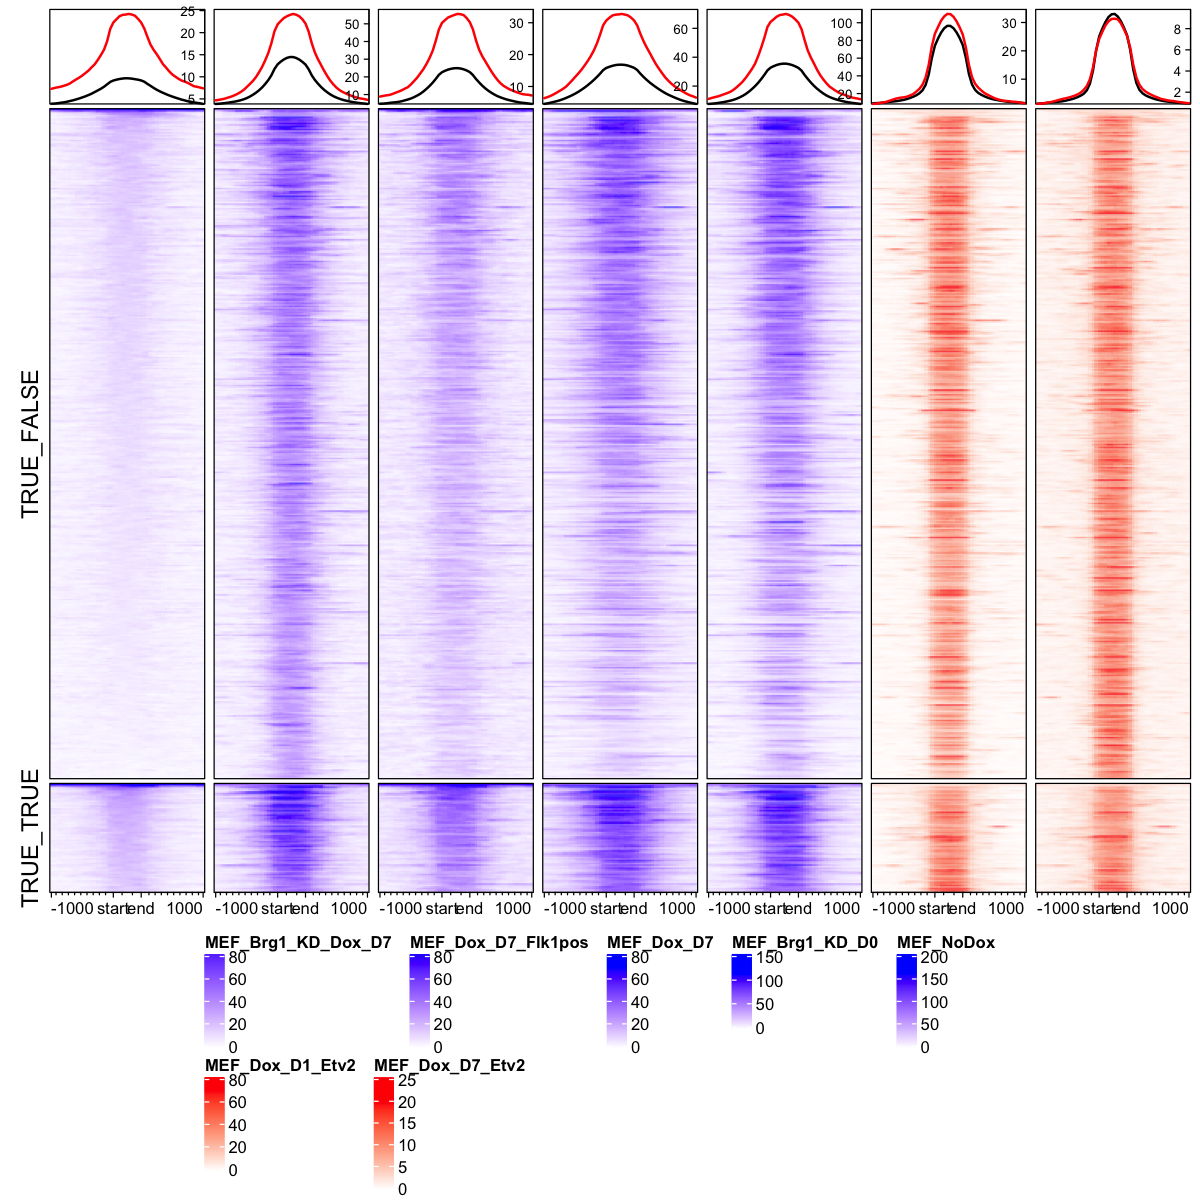

In [228]:
i <- which(open_D7_Flk1pos & !is_black)
sp <- factor(sprintf('%s_%s', open_D7_Flk1pos, open_Brg1KD_D7))
              
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside')
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Brg1_KD_Dox_D7']][i, ], 
  col = col_fun[['MEF_Brg1_KD_Dox_D7']], 
  split = sp[i], 
  name = 'MEF_Brg1_KD_Dox_D7', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D7_Flk1pos','MEF_Dox_D7',
  'MEF_Brg1_KD_D0', 'MEF_NoDox',
  'MEF_Dox_D1_Etv2', 'MEF_Dox_D7_Etv2'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

The **sustaina** Etv2 peaks can be dividied into two groups
* Group 1: closed in Brg1 KO at D7 (TRUE_FALSE)
* Group 2: open in Brg1 KO at D7 (TRUE_TRUE)

In [232]:
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
peak_list <- list(
  open = peaks_sustained[open_D7_Flk1pos & open_Brg1KD_D7],
  closed = peaks_sustained[open_D7_Flk1pos & !open_Brg1KD_D7]
)
anno_list <- lapply(peak_list, function(p)
  annotatePeak(p, tssRegion = c(-5000, 1000), TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene, annoDb = "org.Mm.eg.db")
)

Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

ChIPseeker v1.22.1  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383



>> preparing features information...		 2020-09-03 17:09:12 
>> identifying nearest features...		 2020-09-03 17:09:13 
>> calculating distance from peak to TSS...	 2020-09-03 17:09:13 
>> assigning genomic annotation...		 2020-09-03 17:09:13 
>> adding gene annotation...			 2020-09-03 17:09:36 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2020-09-03 17:09:36 
>> done...					 2020-09-03 17:09:36 
>> preparing features information...		 2020-09-03 17:09:36 
>> identifying nearest features...		 2020-09-03 17:09:36 
>> calculating distance from peak to TSS...	 2020-09-03 17:09:36 
>> assigning genomic annotation...		 2020-09-03 17:09:36 
>> adding gene annotation...			 2020-09-03 17:09:39 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2020-09-03 17:09:39 
>> done...					 2020-09-03 17:09:39 


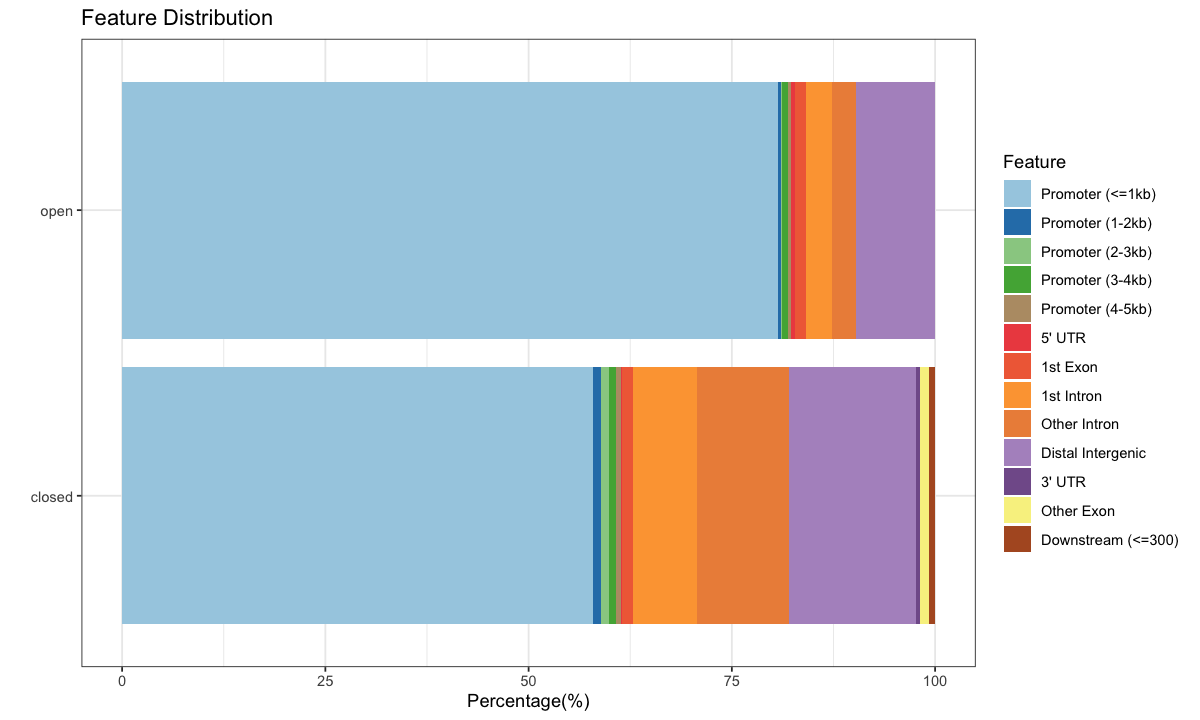

In [235]:
options(repr.plot.width=10, repr.plot.height=6)
plotAnnoBar(anno_list)

In [287]:
library(clusterProfiler)
library(org.Mm.eg.db)

In [284]:
# Find the genes near the peaks
gene_list <- lapply(peak_list, function(p){
  unique(seq2gene(p, tssRegion = c(-5000, 1000), flankDistance = 3000, TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene))
})

In [305]:
pathway_list <- lapply(gene_list, function(g){
  enrichGO(g, keyType = "ENTREZID", OrgDb = org.Mm.eg.db, ont = 'BP', minGSSize = 50, maxGSSize = 1000)
})

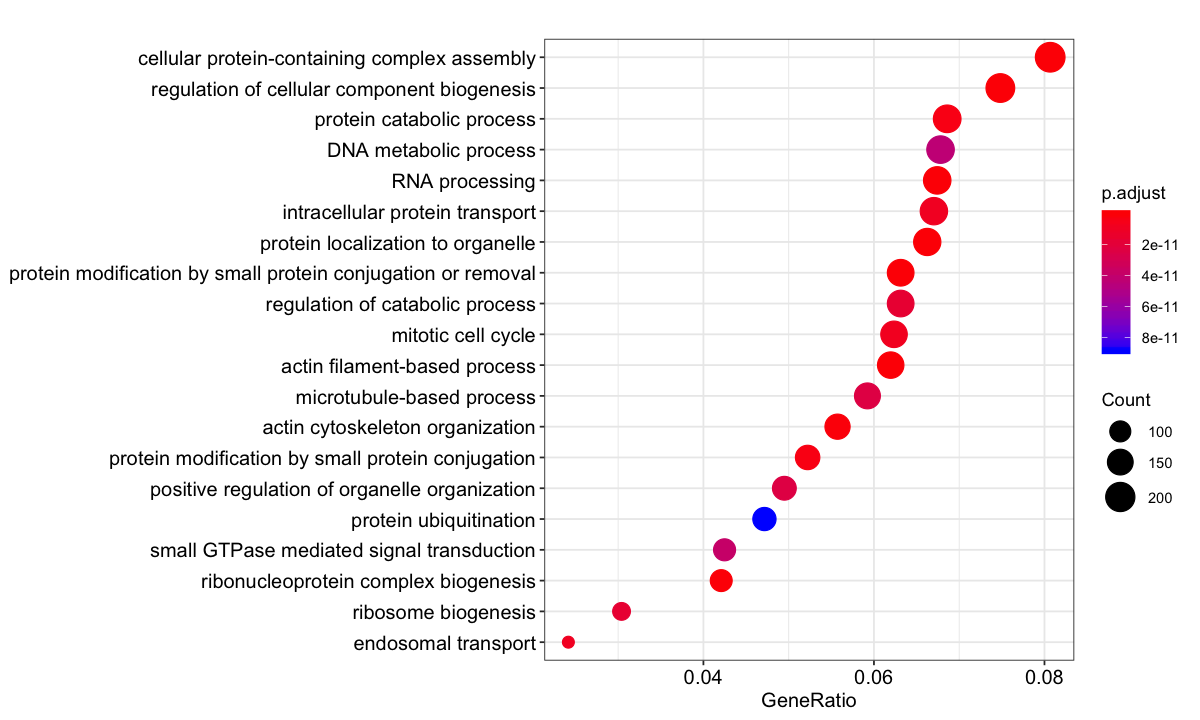

In [306]:
dotplot(pathway_list[['closed']], showCategory = 20)

In [310]:
library(ReactomePA)
pathway_list <- lapply(gene_list, function(g){
  enrichPathway(g, organism = 'mouse')
})

In [311]:
dotplot(pathway_list[['closed']], showCategory = 20)

#### Select the **late** Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction. 

In [3]:
is_late <- !peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']
peaks_late <- peaks[is_late]
cat(sprintf('# of late Etv2 ChIP-seq peaks: %d', sum(is_late)))

# of late Etv2 ChIP-seq peaks: 4222

In [10]:
peak_name <- 'late_Etv2'
n2m_files <- sprintf('data/normalizeToMatrix/peaks=%s_group=%s_extend=%d_w=%d_smooth=%s_target_ratio=%.3f.rds', peak_name, names(bw_files), extend, w, smooth, target_ratio)
mat <- get_normalizeToMatrix(
  local_bw_files, 
  n2m_files, 
  peaks_late, 
  extend = extend, 
  w = w, 
  smooth = smooth, 
  target_ratio = target_ratio, 
  mc.cores = 2, 
  force = FALSE
)
names(mat) <- names(bw_files)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

INFO [2020-09-11 09:11:49] # peaks: 4222
INFO [2020-09-11 09:11:49] target width: 200


### Divide the "late" Etv2 peaks to two group based on the ATAC-seq in Brg1 KD D7

In [16]:
open_Brg1KD_D7 <- peaks_late %over% peaks_Brg1KD_D7
open_D7_Flk1pos <-peaks_late %over% peaks_D7_Flk1pos
is_black <- peaks_late %over% peaks_blacklist

In [17]:
i <- which(open_D7_Flk1pos & !is_black)
sp <- factor(sprintf('%s_%s', open_D7_Flk1pos, open_Brg1KD_D7))
              
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside')
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Brg1_KD_Dox_D7']][i, ], 
  col = col_fun[['MEF_Brg1_KD_Dox_D7']], 
  split = sp[i], 
  name = 'MEF_Brg1_KD_Dox_D7', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D7_Flk1pos','MEF_Dox_D7',
  'MEF_Brg1_KD_D0', 'MEF_NoDox',
  'MEF_Dox_D1_Etv2', 'MEF_Dox_D7_Etv2'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

### Select the early Etv2 ChIP-seq peaks that are present in D1 

In [25]:
is_early <- peaks$group[, 'MEF_Dox_d1_Etv2']
peaks_early <- peaks[is_early]
cat(sprintf('# of early Etv2 ChIP-seq peaks: %d', sum(is_early)))

# of early Etv2 ChIP-seq peaks: 123337

### Get ATAC-seq summits of Brg1 KD at D1 post Etv2 induction

In [26]:
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D1_summits.bed'
peaks_Brg1KD_D1 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_Brg1KD_D1 <- GRanges(seqnames = peaks_Brg1KD_D1[, 1], range = IRanges(peaks_Brg1KD_D1[, 2], peaks_Brg1KD_D1[, 3]))
cat(sprintf('there are %d ATAC-seq summits in Brg1 KD sample at D1 post Etv2 induction', length(peaks_Brg1KD_D1)))

there are 26976 ATAC-seq summits in Brg1 KD sample at D1 post Etv2 induction

### ATAC-seq summits WT MEF reprogramming at D1 post Etv2 induction

In [27]:
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_summits.bed'
peaks_D1 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_D1 <- GRanges(seqnames = peaks_D1[, 1], range = IRanges(peaks_D1[, 2], peaks_D1[, 3]))
cat(sprintf('there are %d ATAC-seq summits in WT MEF reprogramming at D1 post Etv2 induction\n', length(peaks_D1)))

there are 50177 ATAC-seq summits in WT MEF reprogramming at D1 post Etv2 induction


### Divide the "early" Etv2 peaks to two group based on the ATAC-seq in Brg1 KD D1

In [28]:
open_Brg1KD_D1 <- peaks_early %over% peaks_Brg1KD_D1
open_D1 <-peaks_early %over% peaks_D1
is_black <- peaks_early %over% peaks_blacklist
cat(sprintf('there are %d early Etv2 peaks that are open in Brg1 KD sample at D1\n', sum(open_Brg1KD_D1)))
cat(sprintf('there are %d early Etv2 peaks that are open in WT sample at D1\n', sum(open_D1)))
cat(sprintf(
  'there are %d early Etv2 peaks that are open in both Brg1 KD samples and WT samples at D1\n', 
  sum(open_Brg1KD_D1 & open_D1)
))

there are 7808 early Etv2 peaks that are open in Brg1 KD sample at D1
there are 12673 early Etv2 peaks that are open in WT sample at D1
there are 5038 early Etv2 peaks that are open in both Brg1 KD samples and WT samples at D1


### Select a subset of early peaks for visualization

In [29]:
set.seed(1)
i <- (open_Brg1KD_D1 | open_D1) & !is_black
peaks_early2 <- peaks_early[i]
open_Brg1KD_D1 <- open_Brg1KD_D1[i]
open_D1 <- open_D1[i]
cat(sprintf('there are %d early Etv2 peaks that are either open in WT or Brg1 KD sampls at D1', length(peaks_early2)))

there are 15386 early Etv2 peaks that are either open in WT or Brg1 KD sampls at D1

In [30]:
peak_name <- 'early_Etv2'
n2m_files <- sprintf('data/normalizeToMatrix/peaks=%s_group=%s_extend=%d_w=%d_smooth=%s_target_ratio=%.3f.rds', peak_name, names(bw_files), extend, w, smooth, target_ratio)
mat <- get_normalizeToMatrix(
  local_bw_files, 
  n2m_files, 
  peaks_early2, 
  extend = extend, 
  w = w, 
  smooth = smooth, 
  target_ratio = target_ratio, 
  mc.cores = 2, 
  force = TRUE
)
names(mat) <- names(bw_files)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

INFO [2020-09-11 10:46:41] # peaks: 15386
INFO [2020-09-11 10:46:41] target width: 200


### Visualize the heatmap

In [32]:
sp <- factor(sprintf('%s_%s', open_Brg1KD_D1, open_D1))

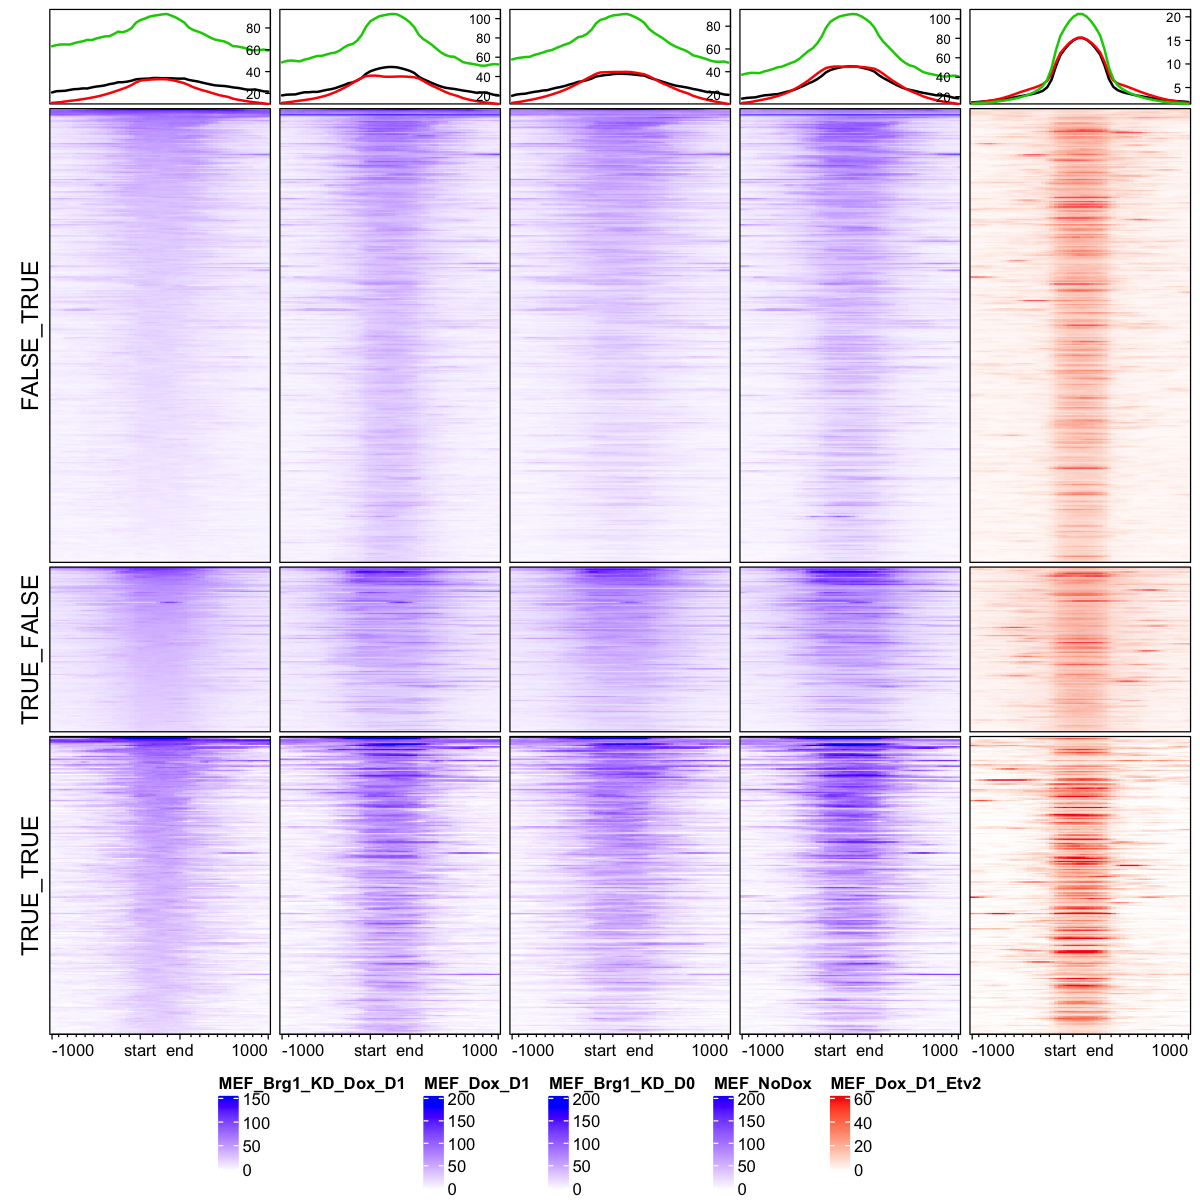

In [35]:
i <- 1:length(peaks_early2)   
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside')
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Brg1_KD_Dox_D1']][i, ], 
  col = col_fun[['MEF_Brg1_KD_Dox_D1']], 
  split = sp[i], 
  name = 'MEF_Brg1_KD_Dox_D1', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D1',
#  'MEF_Dox_D7_Flk1pos','MEF_Dox_D7',
  'MEF_Brg1_KD_D0', 'MEF_NoDox',
  'MEF_Dox_D1_Etv2'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')